# Demo : USGS Data

This is a walkthough of how to run the landmark tools for an example data set. All functions are also documented on the [Run](RUN.md) page.

You can run this demo as a [jupyter notebook](https://docs.jupyter.org/en/latest/running.html). 

## Initialize the notebook environment

Edit the `BUILD_DIR` path to reflect your build directory. `"../build/Release/"` is the default for Xcode. If you are using cmake and you followed my setup instructions, your build directory is `"../build/"`

In [1]:
BUILD_DIR="../build/"
!echo $BUILD_DIR

PYTHON_SCRIPT_DIR="../scripts/python/landmark_tools/"
!echo $PYTHON_SCRIPT_DIR

!rm -r output/earth
!mkdir -p output/earth

../build/
../scripts/python/landmark_tools/


## Dependencies

This demo assumes you have already followed the steps to [Install the tools](INSTALL.md).

Please install [gdal](https://gdal.org/index.html) for manipulating GeoTIFFs.

For the python visualization scripts, you will need the following python libraries

- matplotlib
- numpy
- pillow

Reload the jupyter kernel after installing these libraries.

In [2]:
import matplotlib.pyplot as plt
from PIL import Image

# This sys call is needed because the file is in another directory 
import sys
sys.path.insert(1, '../scripts/python/landmark_tools')
import visualize_corr
import landmark

plt.rcParams['figure.figsize'] = [8, 3]

## Source data

Download maps from https://apps.nationalmap.gov/downloader/. 

We're going to use two USGS DEMs from the same area of Wyoming, with different release dates and investigate the differences between them.

Here's links to the DEM meta data if you want to learn more about them.
- https://www.sciencebase.gov/catalog/item/60e686add34e2a7685cfec45
- https://www.sciencebase.gov/catalog/item/619c837cd34eb622f69328a7 

We're going to use these GeoTIFF to demonstrate most tools available in the landmark tools suite. 

In [3]:
#!wget https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/13/TIFF/historical/n45w108/USGS_13_n45w108_20210615.tif
#!wget https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/13/TIFF/historical/n45w108/USGS_13_n45w108_20211122.tif

## Let's get started

Step 0.

First, we need to learn about our data. What projection is it using? Where is the map located? For this, we use `gdalinfo`

In [4]:
!gdalinfo USGS_13_n45w108_20210615.tif

Driver: GTiff/GeoTIFF
Files: USGS_13_n45w108_20210615.tif
Size is 10812, 10812
Coordinate System is:
GEOGCRS["NAD83",
    DATUM["North American Datum 1983",
        ELLIPSOID["GRS 1980",6378137,298.257222101004,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4269]]
Data axis to CRS axis mapping: 2,1
Origin = (-108.000555556093445,45.000555556294785)
Pixel Size = (0.000092592592692,-0.000092592592692)
Metadata:
  BandDefinitionKeyword=NONE
  DataType=Elevation
  AREA_OR_POINT=Area
Image Structure Metadata:
  LAYOUT=COG
  COMPRESSION=LZW
  INTERLEAVE=BAND
  PREDICTOR=3
Corner Coordinates:
Upper Left  (-108.0005556,  45.0005556) (108d 0' 2.00"W, 45d 0

Looking at this output, this DEM is a GEOGCRS which is a geographic coordinate frame.

Our tools require that the input DEMs be in one of three projections or coordinate frames.
1. Equal rectangular
2. UTM
3. Polar Stereographic
4. Geographic

For demonstration purposes, we will use `gdalwarp` to transform these DEMs to UTM projection for UTM Zone 13N which is "EPSG:32613", but you can also use as is with the geographic coordinate frame. 

In [5]:
!gdalwarp -t_srs "EPSG:32613" -r bilinear USGS_13_n45w108_20210615.tif output/earth/USGS_13_n45w108_20210615_UTM.tif
!gdalwarp -t_srs "EPSG:32613" -r bilinear USGS_13_n45w108_20211122.tif output/earth/USGS_13_n45w108_20211122_UTM.tif

Creating output file that is 9275P x 12701L.
Using internal nodata values (e.g. -999999) for image USGS_13_n45w108_20210615.tif.
Copying nodata values from source USGS_13_n45w108_20210615.tif to destination output/earth/USGS_13_n45w108_20210615_UTM.tif.
Processing USGS_13_n45w108_20210615.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 9275P x 12701L.
Using internal nodata values (e.g. -999999) for image USGS_13_n45w108_20211122.tif.
Copying nodata values from source USGS_13_n45w108_20211122.tif to destination output/earth/USGS_13_n45w108_20211122_UTM.tif.
Processing USGS_13_n45w108_20211122.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


### Step 1. Convert GeoTIFF to a landmark file using create_landmark

First, let's take a look at the arguments for create_landmark

In [6]:
!$BUILD_DIR/create_landmark

Usage for create_landmark:
------------------
  Required arguments:
    -projection <EQ_CYLINDERICAL or UTM or STEREO or GEOGRAPHIC>
    -config_file <filename> - configuration file
  OR
    -geotif_file   <filename> - input dem tif file name
    -lmk_file   <filename> - output lmk file name
    -lmk_width_meters   <filename> - lmk col size
    -lmk_height_meters   <filename> - lmk row size
    -lmk_res   <filename> - lmk resolution
    -lmk_center_lat   <filename> - lmk center lat
    -lmk_center_long   <filename> - lmk center long
  Optional arguments:
    -planet <Moon or Earth> - (default Moon)
    -nodata_value <int> - (default NaN)
    -srm_file <filename> - png image file containing surface reflectance map
    -set_anchor_point_ele <float> - (default NAN, use ele based on a point at anchor lat long)
main() ==>> failed, missing all parameters


We need to choose the extents of our landmark file. 

To convert the entire map area into a landmark file, choose the center point of the map as the anchor point and calculate the width and height of the original map in meters. 

Let's look at the gdal info again to find the center. We're going to do a center 10kmx10km crop of the map.

In [7]:
!gdalinfo USGS_13_n45w108_20210615.tif

Driver: GTiff/GeoTIFF
Files: USGS_13_n45w108_20210615.tif
Size is 10812, 10812
Coordinate System is:
GEOGCRS["NAD83",
    DATUM["North American Datum 1983",
        ELLIPSOID["GRS 1980",6378137,298.257222101004,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4269]]
Data axis to CRS axis mapping: 2,1
Origin = (-108.000555556093445,45.000555556294785)
Pixel Size = (0.000092592592692,-0.000092592592692)
Metadata:
  BandDefinitionKeyword=NONE
  DataType=Elevation
  AREA_OR_POINT=Area
Image Structure Metadata:
  LAYOUT=COG
  COMPRESSION=LZW
  INTERLEAVE=BAND
  PREDICTOR=3
Corner Coordinates:
Upper Left  (-108.0005556,  45.0005556) (108d 0' 2.00"W, 45d 0

The corner coordinates are in the projection coordinate system. In equal rectangular, the center coordinate is exactly what we need.

```
Center      (-107.5000000,  44.5000000) (107d30' 0.00"W, 44d30' 0.00"N)
```

If the landmark file exceeds the size of the input map, the empty data values will be filled with NaN.

In [8]:
!$BUILD_DIR/create_landmark \
    -geotif_file USGS_13_n45w108_20211122.tif \
    -lmk_file output/earth/USGS_13_n45w108_20211122_GEOGRAPHIC.lmk \
    -lmk_width_meters 10000 \
    -lmk_height_meters 10000 \
    -lmk_res 10 \
    -lmk_center_lat 44.5000000 \
    -lmk_center_long -107.5000000 \
    -planet Earth

Geographic coordinate system detected
Creating landmark with empty surface reflectance map.
 0.953716950747703 -0.300705799505935  0.000000000000000
 0.210767480701346  0.668469046300172  0.713250449153274
-0.214478546560602 -0.680239043485890  0.700909264300775


It is also possible to convert geotiff using a configuration file. For this procedure, they must first be converted to a binary format, and a configuration file must be written

In [9]:
# Transform into headerless binary format like ENVI
!gdal_translate -r bilinear -of ENVI output/earth/USGS_13_n45w108_20210615_UTM.tif output/earth/USGS_13_n45w108_20210615_UTM.raw

Input file size is 9275, 12701
0...10...20...30...40...50...60...70...80...90...100 - done.


In [10]:
!gdalinfo output/earth/USGS_13_n45w108_20210615_UTM.tif

Driver: GTiff/GeoTIFF
Files: output/earth/USGS_13_n45w108_20210615_UTM.tif
Size is 9275, 12701
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 13N",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 13N",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",-105,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",500000,
            LENGTHUNIT["metre",1],
         

Use a configuration file to define the parameters

Example: 
```
input:
  filename: output/earth/USGS_13_n45w108_20210615_UTM.raw
  width_px: 9275 
  height_px: 12701 
  bit_depth: 32
  upper_left_x_projection_unit: 259426.934 
  upper_left_y_projection_unit: 4987393.152
  pixel_resolution_projection_unit : 8.947446663191677
  latitude_standard_parallel : 0
  longitude_natural_origin : -105
output:
  filename: output/earth/USGS_13_n45w108_20210615_UTM.lmk
  width_px: 1000
  width_px: 1000
  pixel_resolution_m: 10
  center_latitude: 44.5000000
  center_longitude: -107.5000000

In [11]:
!$BUILD_DIR/create_landmark -projection UTM -planet Earth -nodata_value -999999 -config_file make_20210615_UTM.txt

Creating landmark with empty surface reflectance map.
 0.953716950748155 -0.300705799504502  0.000000000000000
 0.210767480702608  0.668469046304596  0.713250449148754
-0.214478546558221 -0.680239043481901  0.700909264305374


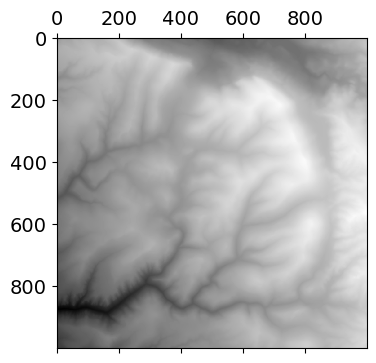

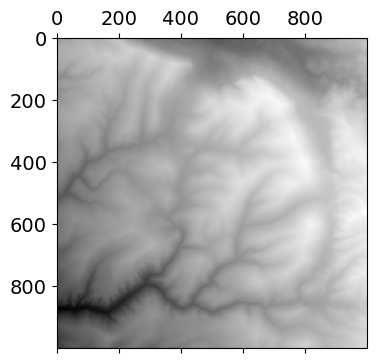

In [12]:
L = landmark.Landmark("/Users/cmauceri/Workspace/LanderVisionSystem/landmark_tools/example/output/earth/USGS_13_n45w108_20210615_UTM.lmk")
plt.matshow(L.ele, cmap='gray')
plt.show()

L = landmark.Landmark("/Users/cmauceri/Workspace/LanderVisionSystem/landmark_tools/example/output/earth/USGS_13_n45w108_20211122_GEOGRAPHIC.lmk")
plt.matshow(L.ele, cmap='gray')
plt.show()

### Step 2. Render map

`create_landmark`'s output will have an empty surface reflectance map. To create proxies for the surface reflectance values, we use the [Blender API]() to render the map.

First, we must make a polygon mesh from the landmark file using the `landmark_2_point` executable. Use the -frame LOCAL option for rendering with the Blender script. It uses the coordinate system of the tangent plane which centers the mesh at the origin and makes it easier to compute the sun angle.

In [13]:
!$BUILD_DIR/landmark_2_point \
  -landmark output/earth/USGS_13_n45w108_20211122_GEOGRAPHIC.lmk \
  -ply output/earth/USGS_13_n45w108_20211122_GEOGRAPHIC.ply \
  -frame LOCAL

                 #! LVS Map v3.0
Landmark file saved at output/earth/USGS_13_n45w108_20211122_GEOGRAPHIC.ply


After generating the mesh, render with `render_ply.py`. 

You will need to choose a sun angle to render from. If you are comparing to a map that has associated orbital imagery, use a sun angle that matches the imagery. In this demo, we are comparing two DEMs that do not have a surface reflectance map based on orbital imagery, so we can choose any sun angle.  

For the demo, I chose sun elevation 30 degrees and azimuth 120 degrees. These are not realistic values for the south pole region, but the output will have fewer shadows which will give us better map coverage in the validation step.

In [14]:
!python $PYTHON_SCRIPT_DIR/render_ply.py \
    output/earth/USGS_13_n45w108_20211122_GEOGRAPHIC.ply \
    30 120 \
    output/earth/USGS_13_n45w108_20211122_GEOGRAPHIC.png \
    -height 1000 \
    -width 1000 \
    -resolution 10

PLY import of 'USGS_13_n45w108_20211122_GEOGRAPHIC.ply' took 244.95 ms
Fra:1 Mem:105.19M (Peak 105.19M) | Time:00:00.00 | Mem:0.00M, Peak:0.00M | Scene, ViewLayer | Synchronizing object | USGS_13_n45w108_20211122_GEOGRAPHIC
Fra:1 Mem:259.47M (Peak 274.73M) | Time:00:00.03 | Mem:0.00M, Peak:0.00M | Scene, ViewLayer | Initializing
Fra:1 Mem:259.33M (Peak 274.73M) | Time:00:00.03 | Mem:0.00M, Peak:0.00M | Scene, ViewLayer | Waiting for render to start
Fra:1 Mem:259.33M (Peak 274.73M) | Time:00:00.03 | Mem:0.00M, Peak:0.00M | Scene, ViewLayer | Loading render kernels (may take a few minutes the first time)
Fra:1 Mem:259.33M (Peak 274.73M) | Time:00:00.03 | Mem:0.00M, Peak:0.00M | Scene, ViewLayer | Updating Scene
Fra:1 Mem:259.33M (Peak 274.73M) | Time:00:00.03 | Mem:0.00M, Peak:0.00M | Scene, ViewLayer | Updating Shaders
Fra:1 Mem:259.42M (Peak 274.73M) | Time:00:00.03 | Mem:0.00M, Peak:0.00M | Scene, ViewLayer | Updating Procedurals
Fra:1 Mem:259.42M (Peak 274.73M) | Time:00:00.03 | Mem:

After rendering with Blender, the generated png file needs to be added to the landmark file. For this, we can use the add_srm executable.

In [15]:
!$BUILD_DIR/add_srm \
  -input output/earth/USGS_13_n45w108_20211122_GEOGRAPHIC.lmk \
  -output output/earth/USGS_13_n45w108_20211122_GEOGRAPHIC_rendered.lmk \
  -srm output/earth/USGS_13_n45w108_20211122_GEOGRAPHIC.png

                 #! LVS Map v3.0
Landmark file written to: output/earth/USGS_13_n45w108_20211122_GEOGRAPHIC_rendered.lmk


Let's visualize the output.

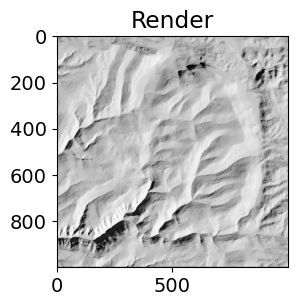

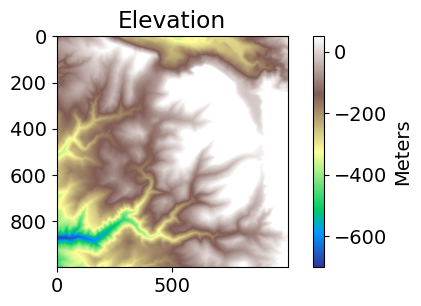

LMK_BODY 0
LMK_ID b'0\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'
LMK_SIZE 1000 1000
LMK_RESOLUTION 10.0
LMK_ANCHOR_POINT -1370810.8649937375 -4347656.614437157 4449791.030557143
LMK_ANCHOR_PIXEL 500.0 500.0
LMK_WORLD_2_MAP_ROT 0.953716950747703 -0.3007057995059345 0.0
LMK_WORLD_2_MAP_ROT 0.21076748070134613 0.6684690463001719 0.7132504491532735
LMK_WORLD_2_MAP_ROT -0.214478546560602 -0.6802390434858896 0.7009092643007749



In [16]:
L0 = landmark.Landmark("output/earth/USGS_13_n45w108_20211122_GEOGRAPHIC_rendered.lmk")

plt.figure()
plt.imshow(L0.srm, cmap='gray')
plt.title("Render")
plt.show()

plt.figure()
plt.imshow(L0.ele, cmap='terrain')
im_ratio = L0.ele.shape[0]/L0.ele.shape[1]
cbar = plt.colorbar(fraction=0.046*im_ratio, pad=0.04)
cbar.set_label('Meters')
plt.clim(-700, 50)
plt.title("Elevation")
plt.show()

print(L0)

Now, we repeat the process for the other map. 

In [17]:
!$BUILD_DIR/landmark_2_point \
-landmark output/earth/USGS_13_n45w108_20210615_UTM.lmk \
-ply output/earth/USGS_13_n45w108_20210615_UTM.ply \
-frame LOCAL

!python $PYTHON_SCRIPT_DIR/render_ply.py \
    output/earth/USGS_13_n45w108_20210615_UTM.ply \
    30 120 \
    output/earth/USGS_13_n45w108_20210615_UTM.png \
    -height 1000 \
    -width 1000 \
    -resolution 10

!$BUILD_DIR/add_srm \
  -input output/earth/USGS_13_n45w108_20210615_UTM.lmk\
  -output output/earth/USGS_13_n45w108_20210615_UTM_rendered.lmk \
  -srm output/earth/USGS_13_n45w108_20210615_UTM.png

                 #! LVS Map v3.0
Landmark file saved at output/earth/USGS_13_n45w108_20210615_UTM.ply
PLY import of 'USGS_13_n45w108_20210615_UTM.ply' took 243.13 ms
Fra:1 Mem:105.19M (Peak 105.19M) | Time:00:00.00 | Mem:0.00M, Peak:0.00M | Scene, ViewLayer | Synchronizing object | USGS_13_n45w108_20210615_UTM
Fra:1 Mem:259.47M (Peak 274.73M) | Time:00:00.02 | Mem:0.00M, Peak:0.00M | Scene, ViewLayer | Initializing
Fra:1 Mem:259.33M (Peak 274.73M) | Time:00:00.02 | Mem:0.00M, Peak:0.00M | Scene, ViewLayer | Waiting for render to start
Fra:1 Mem:259.33M (Peak 274.73M) | Time:00:00.02 | Mem:0.00M, Peak:0.00M | Scene, ViewLayer | Loading render kernels (may take a few minutes the first time)
Fra:1 Mem:259.33M (Peak 274.73M) | Time:00:00.02 | Mem:0.00M, Peak:0.00M | Scene, ViewLayer | Updating Scene
Fra:1 Mem:259.33M (Peak 274.73M) | Time:00:00.02 | Mem:0.00M, Peak:0.00M | Scene, ViewLayer | Updating Shaders
Fra:1 Mem:259.42M (Peak 274.73M) | Time:00:00.02 | Mem:0.00M, Peak:0.00M | Scene, 

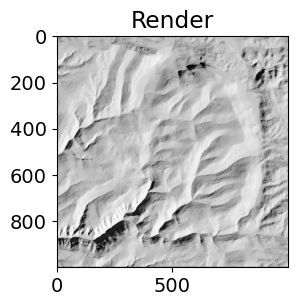

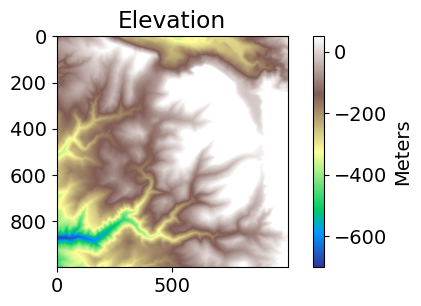

LMK_BODY 0
LMK_ID b'0\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'
LMK_SIZE 1000 1000
LMK_RESOLUTION 10.0
LMK_ANCHOR_POINT -1370810.8649937375 -4347656.614437157 4449791.030557143
LMK_ANCHOR_PIXEL 500.0 500.0
LMK_WORLD_2_MAP_ROT 0.953716950747703 -0.3007057995059345 0.0
LMK_WORLD_2_MAP_ROT 0.21076748070134613 0.6684690463001719 0.7132504491532735
LMK_WORLD_2_MAP_ROT -0.214478546560602 -0.6802390434858896 0.7009092643007749



In [18]:
L0 = landmark.Landmark("output/earth/USGS_13_n45w108_20211122_GEOGRAPHIC_rendered.lmk")

plt.figure()
plt.imshow(L0.srm, cmap='gray')
plt.title("Render")
plt.show()

plt.figure()
plt.imshow(L0.ele, cmap='terrain')
im_ratio = L0.ele.shape[0]/L0.ele.shape[1]
cbar = plt.colorbar(fraction=0.046*im_ratio, pad=0.04)
cbar.set_label('Meters')
plt.clim(-700, 50)
plt.title("Elevation")
plt.show()

print(L0)

### Step 3. Compare maps

Now, we're ready to compare maps. On big maps, it will take a while.

In [19]:
!$BUILD_DIR/landmark_comparison \
  -l1 output/earth/USGS_13_n45w108_20211122_GEOGRAPHIC_rendered.lmk \
  -l2 output/earth/USGS_13_n45w108_20210615_UTM_rendered.lmk \
  -o output/earth/demo_comparison_usgs

No parameter file provided. Using defaults.
feature_match: 
  correlation_window_size: 25
  search_window_size: 36
  min_correlation: 0.300000
forstner_feature_detector: 
  min_dist_feature: 5.000000
  num_features: 600
  forstner_feature_window_size: 9
                 #! LVS Map v3.0
                 #! LVS Map v3.0
line = 0
num_matched_features 2209
i = 0 j = 0
best feat for homography 2209
num_matched_features 2395
i = 0 j = 200
best feat for homography 2395
num_matched_features 2397
i = 0 j = 400
best feat for homography 2397
num_matched_features 2397
i = 0 j = 600
best feat for homography 2397
Ill conditioned peak
num_matched_features 2209
i = 0 j = 800
best feat for homography 2207
line = 200
num_matched_features 2396
i = 200 j = 0
best feat for homography 2396
num_matched_features 2592
i = 200 j = 200
best feat for homography 2592
num_matched_features 2601
i = 200 j = 400
best feat for homography 2601
num_matched_features 2600
i = 200 j = 600
best feat for homography 2600
num_m

This command will produce a whole mess of raw images including 

- `demo_comparison_usgs_delta_x_1000by1000.raw`
- `demo_comparison_usgs_corr_1000by1000.raw`
- `demo_comparison_usgs_delta_z_1000by1000.raw`
- `demo_comparison_usgs_delta_y_1000by1000.raw`

Now we can use the python visualization tools (`scripts/visualize_corr.py`) to look at these results.

The `landmark_comparison` executable generates a vector field representing the displacement between the most highly correlated patches in the two DEMs. Each dimension of the vector field is stored as an image. Let's start by looking at the x-dimension, stored as `<prefix>_delta_x_wbyh.raw`

/Users/cmauceri/Workspace/LanderVisionSystem/github_landmark_tools/example/../scripts/python/landmark_tools/visualize_corr.py:109: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


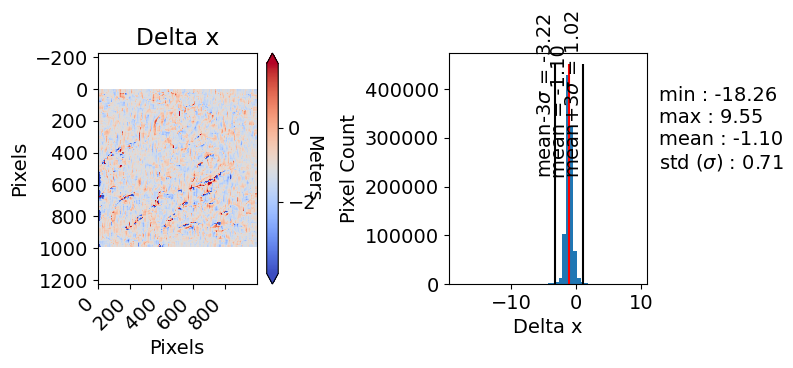

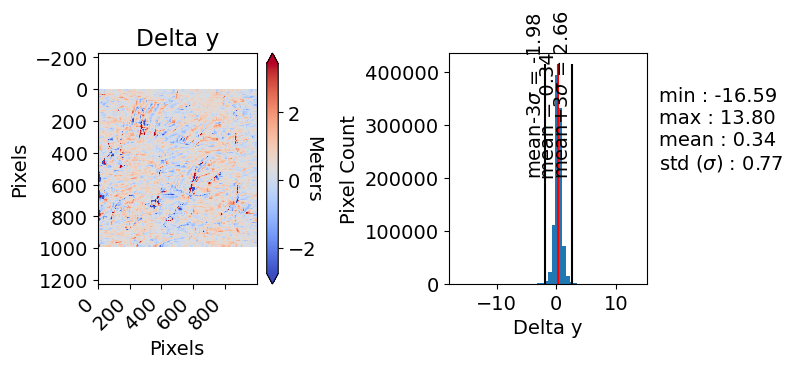

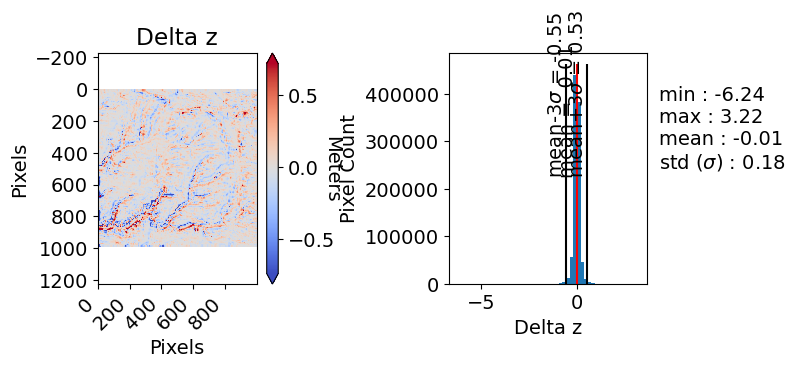

In [20]:
width = 1000
height = 1000
visualize_corr.displayAll("output/earth/demo_comparison_usgs", width, height, "output/earth/demo_comparison_usgs")